In [2]:
import numpy as np
from IPython.display import Audio
from scipy.signal import lfilter
import matplotlib.pyplot as plt

In [3]:
class drumR:
    def __init__(self, p = .5):
        self.p = p
    def __mul__(self, other):
        if isinstance(other, (int, float, complex)): return other * (-1)**np.random.binomial(1, self.p)
        return other * (-1)**np.random.binomial(1, self.p, len(other))
    def __rmul__(self, other): return self * other

In [4]:
def Karplus_Strong(freq : float, dur : float, fs : float, S : float, b, R = 1, dist = 'unif') -> np.array:
    
    N = int(np.round(fs/freq - 1/(2 * S), 0))
    samples = np.zeros(int(np.round(fs * dur, 0)))

    try: samples[ : N] = (2 * np.random.randint(0, 2, N) - 1).astype(float)
    except ValueError: return samples
    
    for i in range(N):
        samples[i] = (samples[i] + samples[i - 1])/2 * R * (-1)**np.random.binomial(1, 1 - b)

    for i in range(N, N * (1 + samples.size//N), N):
        size = min(N, samples.size - i)

        t1 = samples[i - N : i - N + size]
        if i == N: t2 = np.concatenate(([0], samples[i - N : i - N - 1 + size]))
        else: t2 =  samples[i - N - 1 : i - N - 1 + size]

        samples[i : i + N] = R * (t1 / S + t2 * (2 - 1/S)) / 2 * (-1)**np.random.binomial(1, 1 - b, size)

    return samples

In [5]:
def Karplus_Strong_N(dur, fs : float, b, N) -> np.array:
    
    R = S = 1
    samples = np.zeros(int(np.round(fs * dur, 0)))

    try: samples[ : N] = (2 * np.random.randint(0, 2, N) - 1).astype(float)
    except ValueError: return samples
    
    for i in range(N):
        samples[i] = (samples[i] + samples[i - 1])/2 * R * (-1)**np.random.binomial(1, 1 - b)

    for i in range(N, N * (1 + samples.size//N), N):
        size = min(N, samples.size - i)

        t1 = samples[i - N : i - N + size]
        if i == N: t2 = np.concatenate(([0], samples[i - N : i - N - 1 + size]))
        else: t2 =  samples[i - N - 1 : i - N - 1 + size]

        samples[i : i + N] = R * (t1 / S + t2 * (2 - 1/S)) / 2 * (-1)**np.random.binomial(1, 1 - b, size)

    return samples

In [6]:
def Karplus_Strong_Z(freq : float, dur : float, fs : float, S : float, b, R = 1, dist = 'unif') -> np.array:
    N = int(np.round(fs/freq - 1/(2 * S), 0))
    
    x = np.zeros(int(np.round(fs * dur, 0)))
    try:
        if dist == 'unif': x[ : N] = (2 * np.random.randint(0, 2, N) - 1).astype(float)
        else: x[ :N] = np.random.normal(0, 10, N)
    except ValueError: return x
        
    factor = 2 * b - 1
    b_filt = [factor, factor]
    a_filt = np.zeros(N + 2)
    k1 = R * -factor * (2 - 1 / S)
    k2 = R * -factor * (1 / S)
    a_filt[[0, -2, -1]] = [2, k1, k2]
    
    
    return lfilter(b_filt, a_filt, x)

In [87]:
def Karplus_Strong_Z_modif(freq : float, dur : float, fs : float, S : float, coefs) -> np.array:
    N = int(np.round(fs/freq - 1/(2 * S), 0))
    
    x = np.zeros(int(np.round(fs * dur, 0)))
    x[ : N] = (2 * np.random.randint(0, 2, N) - 1).astype(float)
    
    #a, b, c, d = .8995, .1087, 1, .0136
    #a, b, c, d = .9152, .1889, 1, .1127
    #b = c = 1
    #a = .5
    #d = .5
    a, b, c, d = coefs
    
    b_filt = [c, c + d, d]
    a_filt = np.zeros(N + 3)
    k1 = -2 + 1 / S
    k2 = -1 / S
    a_filt[[0, 1, -3, -2, -1]] = [2 * c, 2 * d, a * k1, a * k2 + b * k1, k2 * b]
    
    
    return lfilter(b_filt, a_filt, x)

In [7]:
def Karplus_Strong_ZN(dur, fs : float, b, N) -> np.array:
    
    R = S = 1
    
    x = np.zeros(int(np.round(fs * dur, 0)))
    x[ : N] = (2 * np.random.randint(0, 2, N) - 1).astype(float)
        
    factor = 2 * b - 1
    b_filt = [factor, factor]
    a_filt = np.zeros(N + 2)
    k1 = R * -factor * (2 - 1 / S)
    k2 = R * -factor * (1 / S)
    a_filt[[0, -2, -1]] = [2, k1, k2]
    
    
    return lfilter(b_filt, a_filt, x)

In [8]:
fs = 18000
freq = 450
dur = 2
b = 1
S = 1

sound = Karplus_Strong_Z(freq = freq, dur = dur, fs = fs, S = S, b = b, R = 1)
Audio(sound, rate = fs)

In [9]:
new_num = [.8995, .1087]
new_den = [1, .0136]

new_sound = lfilter(new_num, new_den, sound)
new_sound = lfilter(new_num, new_den, new_sound)

Audio(new_sound, rate = fs)

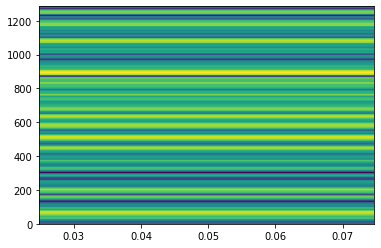

In [10]:
plt.specgram(Karplus_Strong_N(dur = .1, fs = 2570, b = .5, N = 40), Fs = 2570);

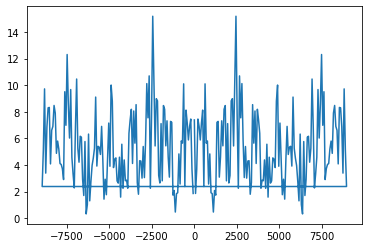

In [11]:
freqs = np.fft.fftfreq(257, 1/fs)
transf = np.fft.fft(Karplus_Strong_N(dur = .1, fs = 2570, b = .5, N = 40))

plt.plot(freqs, np.abs(transf))

(0.0, 25.0)

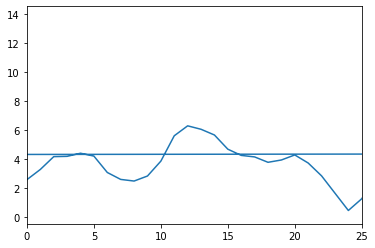

In [12]:
transf = np.abs(np.fft.fft(Karplus_Strong_N(dur = 1, fs = 1000, b = .4, N = 40)))
freqs = np.fft.fftfreq(transf.size, 1/1000)
plt.plot(freqs, transf)
plt.xlim(0, 25)

In [13]:
Audio(sound, rate = fs)

In [54]:
sound = Karplus_Strong_Z(freq = 150, dur = 1, fs = fs, S = 1, R = 1, b = 1)

Audio(sound, rate = fs)

In [92]:
sound2 = Karplus_Strong_Z_modif(freq = 150, dur = 1, fs = fs, S = 1, coefs = [.1, 1, 1, .1])
Audio(sound2, rate = fs)

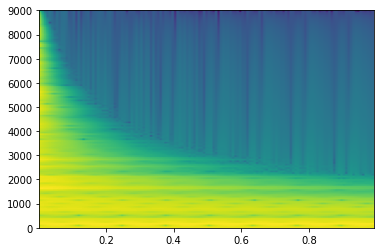

In [94]:
plt.specgram(sound2, Fs = fs);